<a href="https://colab.research.google.com/github/dave502/computer_vision/blob/main/object%20detection%20with%20EfficientDet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%capture
# !pip install tensorflow-object-detection-api
# !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

# # For drawing onto the image.
import numpy as np
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

# For measuring the inference time.
import time

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка предопученной модели efficientdet/d7 <br>
*`EfficientDet Object detection model (SSD with EfficientNet-b7 + BiFPN feature extractor, shared box predictor and focal loss), trained on COCO 2017 dataset.`*

In [ ]:
module_handle = "https://tfhub.dev/tensorflow/efficientdet/d7/1"
detector = hub.load(module_handle)

In [ ]:
# загрузка картинки по указанному пути
def load_image(path, np_format=False):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  converted_img  = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
  if np_format: converted_img = converted_img.numpy()
  return converted_img

# запуск детектора
def run_detector(detector, path, threshold=0.5):
  
  converted_img = load_image(path)

  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()} 
  return result  

In [ ]:
image_path = '/content/drive/MyDrive/MLData/city.jpg'

Запуск модели

In [ ]:
result = run_detector(detector, image_path)

Названия для классов

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Визуализация результата

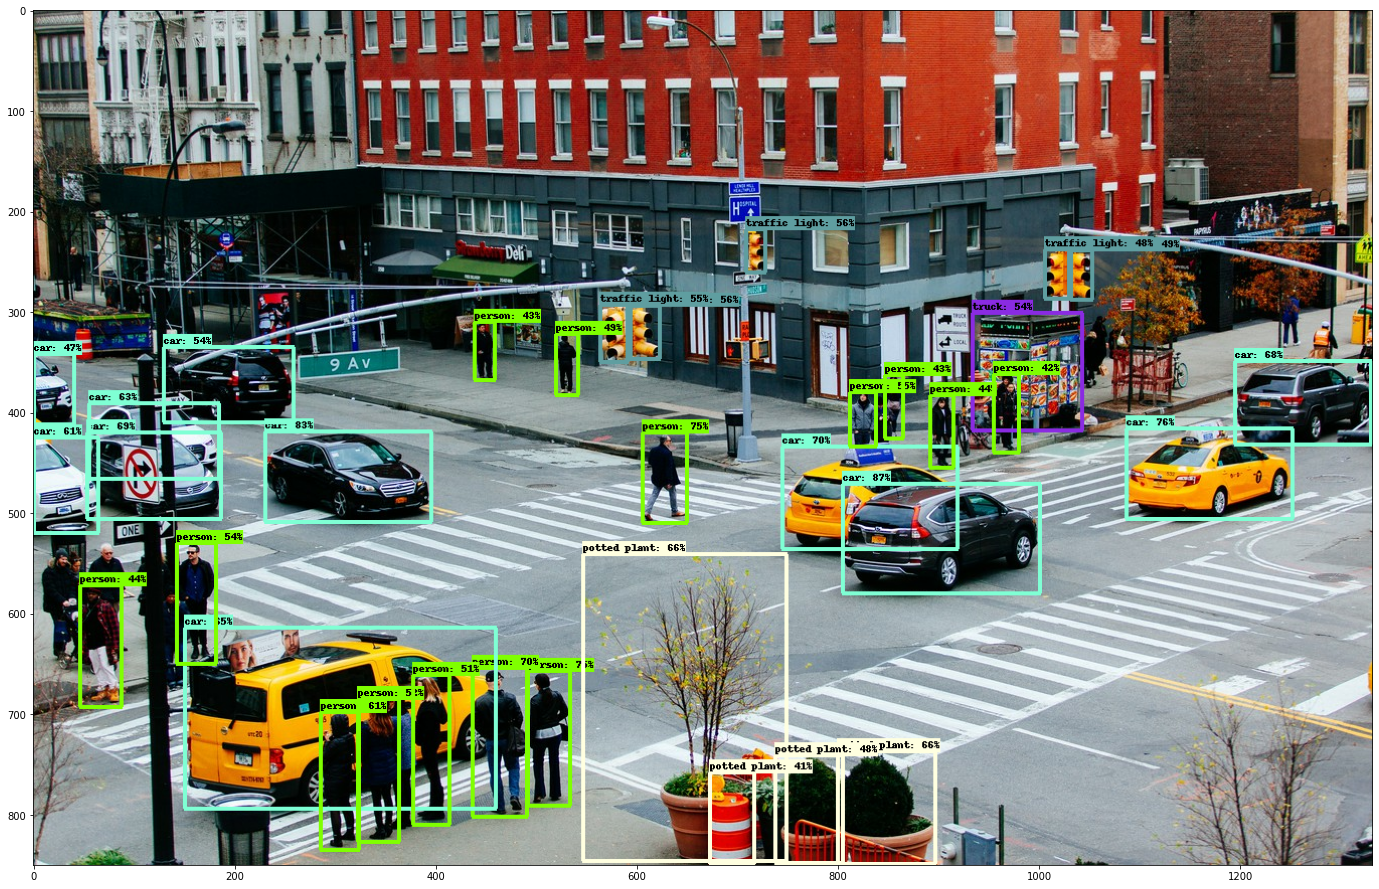

In [ ]:
label_id_offset = 0
image_np_with_detections = load_image(image_path, np_format=True)

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.50,
      agnostic_mode=False,
      keypoints=keypoints)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

Посчитаем среднюю вероятность определения для первых 50 объектов модели efficientdet d7 и сравним с тем же показателем faster rcnn из 7-го дз (картинка одинаковая):

In [ ]:
result['detection_scores'][0][:50].mean()

0.51511145

mean result for faster rcnn - 0.36280382

Показатели score у efficientdet значительно выше. Хотя, конечно, модели уже предобученные и результат зависит от качества обучения, поэтому эту оценку нельзя считать объективной